In [ ]:
# Задача - сегментировать клиентов. У нас есть датасет некой компании WestSuperstore, в котором содержатся все транзакции 
# за определенный период, самые важные колонки - это Customer Id, Sales. Order Date. Они обозначают уникальный id клиента, сумму всего 
# заказа соответственно и дату заказа соответственно. Для сегментации клиентов мы использовали метод LTV, обозначающий зависимость между 
# такими параметрами, как средний чек, число продаж клиенту в месяц, время удержания клиента в месяцах. Исходя из этих параметров мы можем выделить
# несколько сегментов людей, которые могут подойти. Далее будет рассказано подробнее.
# ↓ Здесь мы подключаем все библиотеки и считываем датасет 

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

dataset = pd.read_excel("West_Superstore.xlsx", sheet_name=0)
columns = ["Row ID", "Order ID", "Order Date", "Ship Date", "Ship Mode", "Customer ID", "Customer Name", "Segment",
           "Country", "City", "State", "Postal Code", "Region", "Product ID", "Category", "Sub-Category",
           "Product Name", "Sales", "Quantity", "Discount", "Profit"]


In [ ]:
# Здесь мы представляем датасет в ООП виде, то есть у каждого клиента есть свой список заказов.
# Также мы объявили переменны для записи туда значений LTV

In [3]:
class DateCount:
    def __init__(self, month, year, count):
        self.month = month
        self.year = year
        self.count = count

    def incrementCount(self):
        self.count += 1

class Item:
    def __init__(self, rowID, orderID, orderDate, shipDate, shipMode, customerID, customerName, segment, country, city,
                 state, postalCode, region, productID, category, subCategory, productName, sales, quantity, discount,
                 profit):
        self.rowID = rowID
        self.orderID = orderID
        self.orderDate = orderDate
        self.shipDate = shipDate
        self.shipMode = shipMode
        self.customerID = customerID
        self.customerName = customerName
        self.segment = segment
        self.country = country
        self.city = city
        self.state = state
        self.postalCode = postalCode
        self.region = region
        self.category = category
        self.subCategory = subCategory
        self.productName = productName
        self.sales = sales
        self.quantity = quantity
        self.discount = discount
        self.profit = profit
        self.productID = productID


class Customer:
    def __init__(self, customerID, orders, ltv):
        self.customerID = customerID
        self.customers = orders
        self.ltv = ltv


class LTV:
    def __init__(self, avg_receipt, months, sales_count):
        self.avg_receipt = avg_receipt
        self.months = months
        self.sales_count = sales_count

In [ ]:
# Здесь мы объявили функции для подсчета количества месяцев между 2 датами, и функцию, которая может конвертировать значение,
# изменяющеея в одних пределах, в значение, изменяющееся в других пределах

In [4]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def map(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [ ]:
# Далее мы разгруппировали датасет на клиентов, каждому клиенту мы присвоили его же список заказов. 

In [5]:
y = []

i = 0
while i < len(dataset["Row ID"]):
    consist = False
    n = 0
    while n < len(y):
        if y[n].customerID == dataset["Customer ID"][i]:
            consist = True
            break
        n -= - 1
    item = Item(rowID=dataset["Row ID"][i], orderID=dataset["Order ID"][i], orderDate=dataset["Order Date"][i],
                shipDate=dataset["Ship Date"][i],
                shipMode=dataset["Ship Mode"][i], customerID=dataset["Customer ID"][i],
                customerName=dataset["Customer Name"][i], segment=dataset["Segment"][i],
                country=dataset["Country"][i], city=dataset["City"][i], state=dataset["State"][i],
                postalCode=dataset["Postal Code"][i], region=dataset["Region"][i],
                category=dataset["Category"][i], subCategory=dataset["Sub-Category"][i], sales=dataset["Sales"][i],
                quantity=dataset["Quantity"][i],
                discount=dataset["Discount"][i], profit=dataset["Profit"][i], productID=dataset["Product ID"][i],
                productName=dataset["Product Name"][i])
    if consist:
        y[n].customers.append(item)
    else:
        arr = []
        arr.append(item)
        y.append(Customer(customerID=dataset["Customer ID"][i], orders=arr, ltv=None))
    i -= - 1

In [ ]:
# Здесь происходит вся магия. Здесь мы расчитываем все значения LTV для каждого клиента. Также мы находим самые минимальные
# и максимальные значения среднего чека, числа продаж клиенту в месяц, времени удержания клиента в месяцах.

In [6]:
# LTV
i = 0

# ltv = []

Kmeans_input = []
min_avg_receipt = 99999999999999999999
max_avg_receipt = 0
min_months = 99999999999999999999
max_months = 0
min_sales_count = 99999999999999999999
max_sales_count = 0

while i < len(y):
    n = 0
    sums = 0
    dates = []
    months_sales = []
    while n < len(y[i].customers):
        sums += float(y[i].customers[n].sales)
        datetime = datetime.strptime(str(y[i].customers[n].orderDate), '%Y-%m-%d %H:%M:%S')
        z = 0
        consist = False
        while z < len(months_sales):
            if months_sales[z].month == datetime.month and months_sales[z].year == datetime.year:
                months_sales[z].count += 1
                consist = True
            z -= - 1
        if not consist:
            months_sales.append(DateCount(month=datetime.month, year=datetime.year, count=1))
        dates.append(datetime)
        n -= - 1
    months = diff_month(max(dates), min(dates))

    k = 0
    months_sales_counts = []
    while k < len(months_sales):
        months_sales_counts.append(int(months_sales[k].count))
        k -= - 1

    y[i].ltv = LTV(avg_receipt=(sums / len(y[i].customers)),
                   sales_count=(sum(months_sales_counts) / len(months_sales_counts)), months=months)
    Kmeans_input.append([y[i].ltv.avg_receipt, y[i].ltv.sales_count, y[i].ltv.months])

    if min_avg_receipt > y[i].ltv.avg_receipt:
        min_avg_receipt = y[i].ltv.avg_receipt
    if min_months > y[i].ltv.months:
        min_months = y[i].ltv.months
    if min_sales_count > y[i].ltv.sales_count:
        min_sales_count = y[i].ltv.sales_count

    if max_avg_receipt < y[i].ltv.avg_receipt:
        max_avg_receipt = y[i].ltv.avg_receipt
    if max_months < y[i].ltv.months:
        max_months = y[i].ltv.months
    if max_sales_count < y[i].ltv.sales_count:
        max_sales_count = y[i].ltv.sales_count

    i -= - 1

In [ ]:
# Далее мы конвертируем все данные LTV в значения от [0,4]

In [7]:
Kmeans_input = []

i = 0
while i < len(y):
    Kmeans_input.append([map(y[i].ltv.avg_receipt, min_avg_receipt, max_avg_receipt, 0, 4),
                         map(y[i].ltv.sales_count, min_sales_count, max_sales_count, 0, 4),
                         map(y[i].ltv.months, min_months, max_months, 0, 4)])
    i -= - 1

X = np.array(Kmeans_input)

kmeans_scores = []
kmeans_scores_siluette = []
ints = []


In [ ]:
# Далее мы класторизовали все точки методом k-средних, за метрики брали значения LTV. Чтобы понять, какое количество класторов оптимально,
# воспользуемся методом локтя и методом силуэтов

In [8]:
i = 3
while i < 12:
    kmeans = KMeans(n_clusters=i)
    preds = kmeans.fit_predict(X)
    kmeans_scores.append(abs(kmeans.fit(X).score(X)))
    kmeans_scores_siluette.append(silhouette_score(X, preds, metric='euclidean'))
    ints.append(i)
    i += 1
    

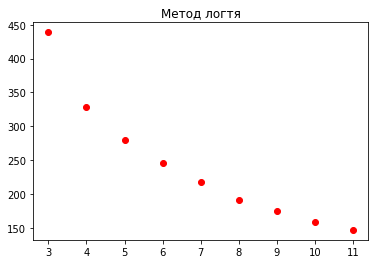

In [9]:
plt.title("Метод логтя")
plt.plot(ints, kmeans_scores, 'ro')
plt.show()

In [ ]:
# На данном графике видно, что разница между 4-7 кластерами не существенно большая, поэтому мы не можем однозначно определить,
# на какое количество кластеров оптимально поделить наших клиентов. Поэтому применим метод силуэта

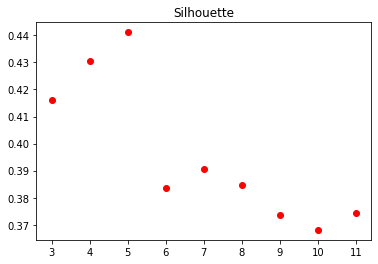

In [10]:
plt.title("Silhouette")
plt.plot(ints, kmeans_scores_siluette, 'ro')
plt.show()

In [ ]:
# На данном графике более точнее видно, что наибольшую выгоду мы получаем при 5 кластеров, тоесть нам нужно разделить клиентов на 5 сегментов.
# Задача выполнена